Die notwendigen Bibliotheken werden importiert und der random seed zur Reproduzierbarkeit der Ergebnisse gesetzt.

In [1]:
# import packages
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors
import seaborn as sns

# ensure reproducable results
from numpy.random import seed
seed(1)

Für die zwei verschiedenen Settings definieren wir zwei Funktionen, die das Kundenwahlverhalten beschreiben. Die erste Funktion beschreibt, dass das Verhalten statisch ist und sich nicht über den Tag ändert. In diesem Fall ist der Preis 3€ derjenige, der den höchsten Erwartungswert i.H.v. 0.6€ liefert und eine optimale Politik setzt in Setting 1 stets den Preis 3€. Bei der zweiten Funktionen ändern sich die Kaufwahrscheinlichkeiten bei t>=5 so, dass in dieser zweiten Tageshälfte der Preis 4€ den höchsten Erwartungswert i.H.v. 1.6€ liefert. Die optimale Politik in Setting 2 setzt also den Preis 3€ für t<5 und den Preis 4€ für t>=5.

In [2]:
def customer_decision_static(price):
    # static customer behavior, probability to buy not dependent on time
    if price == 3:
        decision_prob = 0.2
    elif price == 4:
        decision_prob = 0.1
    elif price == 5:
        decision_prob = 0.05
    
    rand = np.random.uniform(0,1)
    
    if rand <= decision_prob:
        decision = 1
    else:
        decision = 0
    
    return decision

def customer_decision_dynamic(price,time):
    # dynamic customer behavior, probability to buy dependent on time
    # optimum: 5*3*0.15+5*4*0.2=6.25
    
    if price == 3:
        decision_prob = 0.2
    elif price == 4:
        decision_prob = 0.1
    elif price == 5:
        decision_prob = 0.05
    
    if time >= 5:
        if price == 3:
            decision_prob = 0.4
        elif price == 4:
            decision_prob = 0.4
        elif price == 5:
            decision_prob = 0.3
    
    rand = np.random.uniform(0,1)
    
    if rand <= decision_prob:
        decision = 1
    else:
        decision = 0
    
    return decision

Die Funktion update_Q_time führt das Update der Q-Matrix durch. Da die approximierten Q-Werte des Folgezustandes benutzt werden, handelt es sich beim Q-Learning um ein Temporal Difference Learning Verfahren, genauer ein TD(0)-Verfahren. Die Schrittweite alpha kann sich dabei bei Bedarf lienar über den Lernprozess ändern.

In [3]:
def update_Q_time(Q, time, time_prime, price_idx, revenue, episode, episodes):
    # updates Q-matrix with learning rate alpha and discount factor gamma
    
    alpha_init = 0.01
    alpha_final = 0.01
    
    alpha = alpha_init - (alpha_init-alpha_final)*episode/len(episodes)

    gamma = 0.95
    
    # update according to Sutton, Barto 2018 (p. 131) or https://towardsdatascience.com/a-beginners-guide-to-q-learning-c3e2a30a653c
    Q[time, price_idx] = Q[time, price_idx] + alpha*(revenue + gamma*np.max(Q[time_prime]) - Q[time, price_idx])
    
    return Q

Die Funktion pricing_decision_time bestimmt den Preis während des gesamten Lernprozesses. Es handel sich beim Q-Learning um ein Off-Policy Learning Verfahren. Die eigentliche Politik, d.h. die Target Policy, nach der gesucht wird, ergibt sich durch Suche nach derjenigen Aktion a, die beim Zustand S den höchsten erwarteten Erlös generiert, d.h. arg_max(Q[S,a]). Während des Lernprozesses wird allerdings eine andere Politik, nämlich eine epsilon-greedy Politik verwendet. Mit Wahrschenilichkeit epsilon, wird aus den nicht-greedy-Aktionen eine zufällige Aktion gewählt, damit der gesamte Zustands-Aktionen-Raum "erforscht" werden kann (Explorarion). Mit 1-epsilon wird die zu diesem Zeitpunkt beste Aktion gewählt (Exploitation). Das epsilon passt sich über den Lernprozess an, zunächst wird relativ viel "explored", später haputsächlich "exploited".

In [4]:
def pricing_decision_time(Q, time, prices, episode, episodes):
    # pricing decision according to epsilon-greedy exploration, exploitation
    # return price index and price
    # epsilon-greedy: exploration with probability epsilon, exploitation with probability 1-epsilon
    # epsilon depends linearly on learning progess, begins with eps_init, ends with eps_final
    
    eps_init = 0.5
    eps_final = 0.01
    
    eps = eps_init - (eps_init-eps_final)*episode/len(episodes)
    
    # print(eps)

    rand = np.random.uniform(0,1)
    
    greedy_price_idx = np.argmax(Q[time])
    
    if rand >= eps:
        # greedy: best action according to current Q-matrix
        
        price_idx = greedy_price_idx
        price = prices[greedy_price_idx]
    else:
        # random action
        
        if len(prices) > 1: # if only one action possible, there is no non greedy action
            price_idxs = list(range(len(prices)))
            price_idxs.remove(greedy_price_idx)
        
        price_idx = np.random.choice(price_idxs)
        price = prices[price_idx]
    
    # print(price)
    
    return price_idx, price

# Setting 1 - Statisches Kundenwahlverhalten

Das Setup besteht aus 5000 Episoden, in denen jede Episode aus jeweils 10 Zeitperioden besteht. Es können 3 Preise gesetzt werden und die Q-Matrix wird mit überschätzten Werten initialisiert, da dies zur Exploration beiträgt.

In [5]:
# settings
episodes = range(5000)
times = range(11)

prices = [3,4,5]

# initialize Q-matrix
Q = 10*np.ones((len(times), len(prices)))

# tracking progress of learning
revenues_cum_episodes = []
revenues_cum_mean_episodes = []

Nun folgt der eigentliche Lernprozess. Die äußere Schleife iteriert über die Episoden, die innere über die Zeitpunkte. Die Annahme in diesem Setting ist, dass in jeder Periode ein Kunde eintrifft. Über den Lernprozess ändern entsprechend der (zunehmend gelernten) getroffenen Entscheidungen und den Realisierungen der zufälligen Kundenentscheidungen unterschiedliche Erlöse über den gesamten Tag. Diese werden im Verlauf über den Lernprozess zur anschließenden Auswertung festgehalten.

In [6]:
# learning process
# two loops with outer loop over episodes and inner loop for time steps within each episode

# loop over learning episodes
for episode in episodes:
    
    # (re)set initial values for new episode
    decisions = []

    revenues_cum = []
    
    # loop over time steps in each episode
    # assumption that every time step one customer arrival
    for time in times[:-1]:
         
        # pricing decision with current Q-matrix and epsilon-greedy method
        price_idx, price = pricing_decision_time(Q, time, prices, episode, episodes)
        
        # determine customer decision and update state
        decision = customer_decision_static(price) # setting 1
        # decision = customer_decision_dynamic(price,time) # setting 2
        decisions.append(decision)
        
        revenue = decision*price
        
        if time == 0:
            revenues_cum.append(revenue)
        else:
            revenues_cum.append(revenues_cum[-1]+revenue)
        
        # update Q-matrix
        Q = update_Q_time(Q, time, time+1, price_idx, revenue, episode, episodes)
        
    # tracking cumulated revenues
    revenues_cum_episodes.append(revenues_cum[-1])
    if episode == 0:
        revenues_cum_mean_episodes.append(revenues_cum[-1])
    else:
        # incremental averaging of cumulated revenues
        revenues_cum_mean_episodes.append(revenues_cum_mean_episodes[-1]+(revenues_cum[-1]-revenues_cum_mean_episodes[-1])/(len(revenues_cum_mean_episodes)+1))     

Nun werden die Ergebnisse visualisiert.

Text(33.0, 0.5, 'prices')

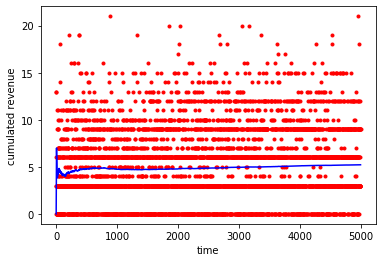

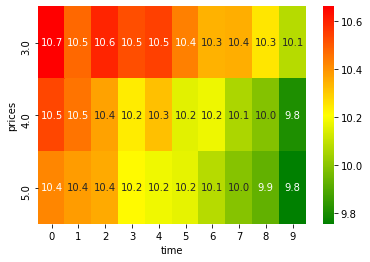

In [7]:
# visualization
# revenues_cum
fig, axes = plt.subplots(1,1)
axes.plot(episodes,revenues_cum_episodes,'r.')
axes.plot(episodes,revenues_cum_mean_episodes,'b')
plt.xlabel('time')
plt.ylabel('cumulated revenue')

# visualize Q values
figure = plt.figure()
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])

yticklabels = np.linspace(prices[0],prices[-1],len(prices))

sns.heatmap(np.transpose(Q[:-1,:]), annot=True, yticklabels=yticklabels, cmap=cmap, fmt='.1f')
plt.xlabel('time')
plt.ylabel('prices')

Die obere Abbildung zeigt den Verlauf des durchschnittlichen kumulierten Erlöses über die 5000 Episoden in blau, während die roten Punkte die tatsächlichen Erlöse in diesen Episoden repräsentieren. Der durschnittliche kumulierte erwartete Erlös kovergiert gegen den optimalen Erwartungswert bei 10\*3€\*20\%=6€, der sich aus den 10 Perioden und dem optimalen Erwartungswert i.H.v. 0.6€ pro Periode, wie oben beschriebenen, ergibt.

Dieser Wert ergibt sich, da für alle Zeitpunkte t der Q-Wert des Preises 3€ der größte, d.h. unabhängig vom Zeitpunkt setzt die gelernte Politik den Preis 3€, da dieser den größen Erwartungswert verspricht. Diese Q-Werte sind in der unteren Abbildung dargestellt. Das Q-Learning hat in diesem Setting also die optimale Politik gelernt. Die Q-Werte an sich können in diesem Fall nicht einfach interpretiert werden, da sie mit dem Wert 10 initialisiert wurden. Bei einer Initialisierung von 0 würden sie dem diskontierten erwarteten Erlös entsprechen, allerdings dient die hier gewählte Initialisierung auch der Exploration, was dem Vorteil der einfachen Interpretierbarkeit klar überwiegt.

# Setting 2 - Dynamisches Kundenwahlverhalten

Der Unterschied zum ersten Setting ist besteht darin, dass sich die Kunden nun entsprechend der Funktion customer_decision_dynamic(price,time) verhalten, d.h. bei t>=5 eine höhere Kaufwahrscheinlichkeit bei denselben Preisen vorliegt.

Text(33.0, 0.5, 'prices')

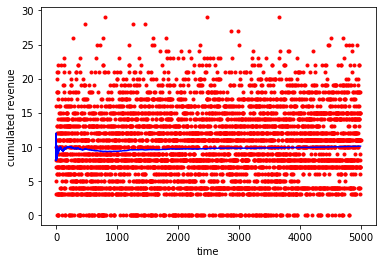

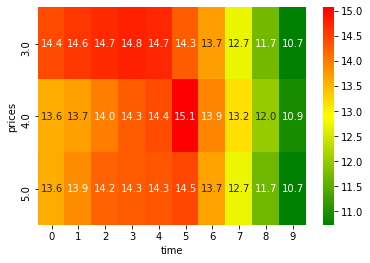

In [8]:
# settings
episodes = range(5000)
times = range(11)

prices = [3,4,5]

# initialize Q-matrix
Q = 10*np.ones((len(times), len(prices)))

# tracking progress of learning
revenues_cum_episodes = []
revenues_cum_mean_episodes = []

# tracking optimal prices
optimal_prices_episodes = []
optimal_prices_avg_episodes = []

# learning process
# two loops with outer loop over episodes and inner loop for time steps within each episode

# loop over learning episodes
for episode in episodes:
    
    # (re)set initial values for new episode
    decisions = []

    revenues_cum = []
    
    # loop over time steps in each episode
    # assumption that every time step one customer arrival
    for time in times[:-1]:
         
        # pricing decision with current Q-matrix and epsilon-greedy method
        price_idx, price = pricing_decision_time(Q, time, prices, episode, episodes)
        
        # determine customer decision and update state
        # decision = customer_decision_static(price) # setting 1
        decision = customer_decision_dynamic(price,time) # setting 2
        decisions.append(decision)
        
        revenue = decision*price
        
        if time == 0:
            revenues_cum.append(revenue)
        else:
            revenues_cum.append(revenues_cum[-1]+revenue)
        
        # update Q-matrix
        Q = update_Q_time(Q, time, time+1, price_idx, revenue, episode, episodes)
        
    # tracking cumulated revenues
    revenues_cum_episodes.append(revenues_cum[-1])
    if episode == 0:
        revenues_cum_mean_episodes.append(revenues_cum[-1])
    else:
        # incremental averaging of cumulated revenues
        revenues_cum_mean_episodes.append(revenues_cum_mean_episodes[-1]+(revenues_cum[-1]-revenues_cum_mean_episodes[-1])/(len(revenues_cum_mean_episodes)+1))

    # tracking optimal prices
    optimal_prices = np.argmax(Q, axis=1).copy()

    for i in range(len(prices)):
        np.place(optimal_prices, optimal_prices==i, prices[i])

# visualization
# revenues_cum
fig, axes = plt.subplots(1,1)
axes.plot(episodes,revenues_cum_episodes,'r.')
axes.plot(episodes,revenues_cum_mean_episodes,'b')
plt.xlabel('time')
plt.ylabel('cumulated revenue')

# visualize Q values
figure = plt.figure()
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])

yticklabels = np.linspace(prices[0],prices[-1],len(prices))

sns.heatmap(np.transpose(Q[:-1,:]), annot=True, yticklabels=yticklabels, cmap=cmap, fmt='.1f')
plt.xlabel('time')
plt.ylabel('prices')

In Setting 2 ist der Preis 4€ für t>=5 optimal. Entsprechend sind die Q-Werte in der zweiten Abbildung für diese Zustand-Aktion-Kombinationen die größten, sodass auch hier das Q-Learning die optimale Politik gelernt hat. Der durchschnittliche kumulierte Erwartungswert, in der oberen Abbildung wieder in blau dargestellt, konvergiert gegen 5\*3€\*20%+5\*4€\*40%=11€.